In [1]:
import pandas as pd
import numpy as np
import os

#load ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import plotly.express as px

# figure size in inches
%matplotlib inline
rcParams['figure.figsize'] = 11.7,8.27

#suppress warnings
import warnings
warnings.filterwarnings("ignore")


# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


The dataset are collected from ~ https://agmarknet.gov.in/ <br/>


In [22]:
full_data = pd.read_csv('drive/My Drive/datasets/agmarket/rest_28april/full_lat_long_mandi.csv',drop) 
#full_data = full_data[:,1:]
full_data.drop(['Unnamed: 0'],axis=1,inplace=True)
full_data['price_date']=pd.to_datetime(full_data['price_date'])

full_data.shape,full_data.columns

((2946365, 16),
 Index(['district_name', 'market_name', 'commodity', 'variety', 'grade',
        'minprice_perquintal', 'maxprice_perquintal', 'modalprice_perquintal',
        'price_date', 'year', 'month', 'month_year', 'lower_market_name',
        'latitude', 'longitude', 'lat_searched_on'],
       dtype='object'))

In [19]:
full_data.head(2)

,Unnamed: 0,district_name,market_name,commodity,variety,grade,minprice_perquintal,maxprice_perquintal,modalprice_perquintal,price_date,year,month,month_year,lower_market_name,latitude,longitude,lat_searched_on
0,0,Fatehabad,Fatehabad,Tomato,Other,FAQ,1000.0,1200.0,1000.0,2018-01-16,2018,1,1_2018,Fatehabad,27.027668,78.207434,fatehabad
1,1,Fatehabad,Fatehabad,Tomato,Other,FAQ,1000.0,1100.0,1000.0,2018-01-12,2018,1,1_2018,Fatehabad,27.027668,78.207434,fatehabad


The count of veggies prices captured  by the agmarket website on yearly basis varies for different commodities all over india.<br/>


*   These uneveness among commodities might indicate what majority of conception of veggies in the indian population
*   Or the data itself is not stored on daily basis as promised by agmarket website for each of the commodities

Green chilli,Tomato,Onion,bhindi,Brinjal are the commodities were counts are approximately equal which is good thing for further analysis.

As for our further analysis we will consider green chilli as commodity for further analysis since the amount of data collected across years seems  almost same.<br/>

Potato,cauliflower,capsicum,seetaphal,groundnut pods are the commodities where prices are recorded irregular,which might not help in finding year on year analysis in our dataset.So we are removing these commodities as of now.



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

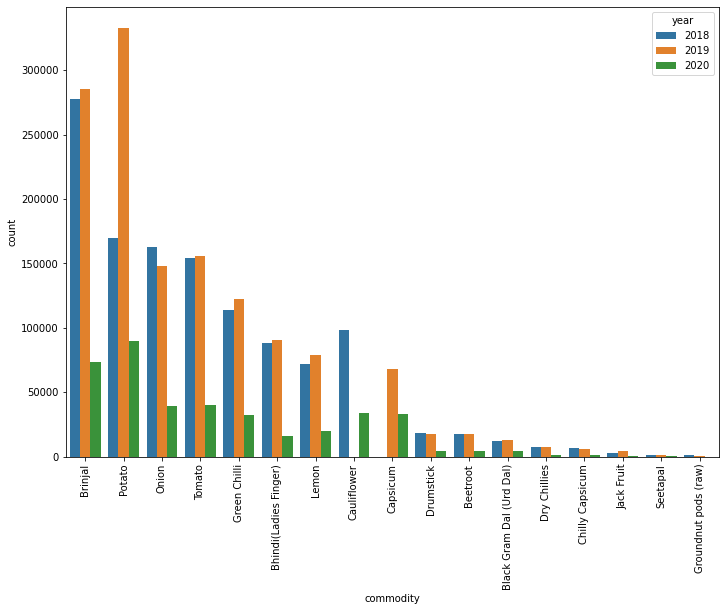

In [30]:
sns.countplot(x = 'commodity',data = full_data,hue="year",order = full_data['commodity'].value_counts().index)
plt.xticks(rotation=90)

In [102]:

partial_commodity = full_data[~full_data.commodity.isin(['Potato','Capsicum','Cauliflower','Groundnut pods (raw)'])]

Lets plot the distribution of each of the commodities (modal price) based on year-on-year basis.With this we can know how much of increase in price fluctuated year-on-year for each of the commodities<br/>
It Seems year-on-year drumstick prices are increasing which might imply (demand & supply)curve is fluctuating between consumers and producers or inflation cost  is rising the prices<br/>
To check the distribution of all the commodity yearwise ,kindly click on this link which will direct you to Tableau sheets where all the charts are self explantatory<br/> 

Note:low performing months for 2020 (drumstick) are yet to happen which might change the above hypthosis,which can be inferred by next plot

In [103]:

fig = px.box(partial_commodity[(partial_commodity['commodity']=='Drumstick')], x="variety", y="modalprice_perquintal", color="year")
#fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

Its clear from the below plot the prices of the drumstick are comparatively high in the month of Nov,Dec,Jan,Feb.<br/>
For the month of April,May the drumstick prices are cheap



In [104]:

fig = px.box(partial_commodity[(partial_commodity['commodity']=='Drumstick')], x="variety", y="modalprice_perquintal", color="month")
#fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

Now we will Try to Forecast the prices of the drumstick for two markets seperately into the future 7days,30 days,60 days<br/>
As per literature note the error term into the future increases as number of days increases<br/>
Lets first select the few markets where we have sufficient data to forecast into the future,we will mainly focus on Pune,Mumbai,Mysore

In [100]:
partial_commodity[(partial_commodity['commodity']=='Drumstick')]['market_name'].value_counts().nlargest(10)

Kayamkulam             782
Manjeswaram            780
Surat                  751
Manjeri                679
Dahod(Veg. Market)     677
Jajpur                 674
Palayam                631
Mysore (Bandipalya)    629
Pune                   623
Mumbai                 609
Name: market_name, dtype: int64

We will first try to build a univariate forecasting model where we will track the error rate with different future prediction i,e 7,30,60 days into future

In [121]:

partial_commodity_market = partial_commodity[partial_commodity.market_name.isin(['Pune','Mysore (Bandipalya)','Mumbai'])]


Lets plot the data available mandi wise to see whither there is any trend ,seasonality,cyclic & Noise pattern available in the raw dataset

In [137]:
plot_data = partial_commodity_market[(partial_commodity_market['commodity']=='Drumstick') & (partial_commodity_market['market_name']=='Mumbai')].sort_values(by='price_date')
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_data['price_date'], y=plot_data['maxprice_perquintal'],
                    mode='lines+markers',
                    name='Max Price'))
fig.add_trace(go.Scatter(x=plot_data['price_date'], y=plot_data['modalprice_perquintal'],
                    mode='lines',
                    name='Modal Price'))
fig.add_trace(go.Scatter(x=plot_data['price_date'], y=plot_data['minprice_perquintal'],
                    mode='lines', name='Min Price'))
# Add range slider
fig.update_layout(
    title='Drumstick prices in Mumbai market',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)


fig.show()

In [138]:
plot_data = partial_commodity_market[(partial_commodity_market['commodity']=='Drumstick') & (partial_commodity_market['market_name']=='Pune')].sort_values(by='price_date')
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_data['price_date'], y=plot_data['maxprice_perquintal'],
                    mode='lines+markers',
                    name='Max Price'))
fig.add_trace(go.Scatter(x=plot_data['price_date'], y=plot_data['modalprice_perquintal'],
                    mode='lines',
                    name='Modal Price'))
fig.add_trace(go.Scatter(x=plot_data['price_date'], y=plot_data['minprice_perquintal'],
                    mode='lines', name='Min Price'))
# Add range slider
fig.update_layout(
    title='Drumstick prices in Pune market',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)


fig.show()

In [139]:
plot_data = partial_commodity_market[(partial_commodity_market['commodity']=='Drumstick') & (partial_commodity_market['market_name']=='Mysore (Bandipalya)')].sort_values(by='price_date')
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_data['price_date'], y=plot_data['maxprice_perquintal'],
                    mode='lines+markers',
                    name='Max Price'))
fig.add_trace(go.Scatter(x=plot_data['price_date'], y=plot_data['modalprice_perquintal'],
                    mode='lines',
                    name='Modal Price'))
fig.add_trace(go.Scatter(x=plot_data['price_date'], y=plot_data['minprice_perquintal'],
                    mode='lines', name='Min Price'))
# Add range slider
fig.update_layout(
    title='Drumstick prices in Mysore market',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)


fig.show()

Next we will carryout some univariate time series forecasting method ,just to check how much can we accuratly forecast the prices